# Plotting LEGO Data with Python and Pandas

When the first wave of COVID-19 hit Germany in spring 2020 and everyone started their lockdown hobby, I decided to start sorting my LEGO bricks. Little did I know that I opened up Pandora's box with that. To make it short: this project is not finished yet and by now I doubt that it ever will. 

While sorting through the last decades of LEGO, I quickly recognized some trends. For example, most the iconic [2x4 bricks](https://www.bricklink.com/v2/catalog/catalogitem.page?P=3001#T=C) that everyone associates with LEGO were very old. It seems that this classic brick is even less popular than I thought beforehands. On the other hand I was astonished, how many [1x2 plates](https://www.bricklink.com/v2/catalog/catalogitem.page?P=3023#T=C) I obtained through the years.

A quick Google search revealed that *Rebrickable* offers a huge LEGO database for download at https://rebrickable.com/downloads/. Because I was interested in data analysis with Python, I grabbed the opportunity and tried to find out, whether or not I could create some interesting plots about the evolution of LEGO bricks. Here, I want to share some first results, when I looked into the brick colors.

## Preparing the Data Set 

Let's start with importing the libraries. In the next step I am loading the csv files (that I downloaded from Rebrickable and saved in a folder `data`) with panda's `read_csv()` function.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

colors = pd.read_csv('data/colors.csv')
inventories = pd.read_csv('data/inventories.csv')
inventory_parts = pd.read_csv('data/inventory_parts.csv')
sets = pd.read_csv('data/sets.csv')

Next, I merge the different DataFrames into a single DataFrame. This DataFrame contains information about all bricks since 1949.

In [2]:
# Merge on key
df = pd.merge(inventories, sets, how='left', left_on=['set_num'], right_on=['set_num'])
df = pd.merge(df, inventory_parts, how='left', left_on=['id'], right_on=['inventory_id'])
df = pd.merge(df, colors, how='left', left_on=['color_id'], right_on=['id'])

`.describe()` is a handy function to get quick statistics on the numeric columns of the DataFrame. You can see that the first year (__min__ of __year__) is indeed the year of 1949. 

Something interesting that strucked me here is the __max__ of __num_parts__, so the maximum number of parts in a set. The database contains a set with 9,987 bricks! However, the LEGO set with the highest number of bricks as of today is the *10276 Colloseum* with only 9,036 bricks.

In [3]:
df.describe()

,id_x,version,year,theme_id,num_parts,inventory_id,color_id,quantity,id_y
count,885528.00000,885528.000000,835788.000000,835788.000000,835788.000000,883210.000000,883210.000000,883210.000000,883210.000000
mean,21853.00518,1.063634,2008.949127,353.415401,620.526943,21820.226303,106.676630,3.280416,106.676630
std,21045.90867,0.295775,11.209785,228.058466,901.623679,21011.268548,766.123959,8.812455,766.123959
min,1.00000,1.000000,1949.000000,1.000000,0.000000,1.000000,-1.000000,1.000000,-1.000000
25%,7040.00000,1.000000,2004.000000,155.000000,146.000000,7037.000000,3.000000,1.000000,3.000000
50%,13903.00000,1.000000,2013.000000,389.000000,362.000000,13901.000000,15.000000,2.000000,15.000000
75%,30014.00000,1.000000,2017.000000,576.000000,733.000000,29994.000000,71.000000,3.000000,71.000000
max,89176.00000,8.000000,2021.000000,712.000000,9987.000000,89176.000000,9999.000000,1440.000000,9999.000000


Let's investigate this mysterious set with 9,987 parts/bricks. It turns out this was a huge set from the Chima theme that was never available to retail: https://rebrickable.com/sets/BIGBOX-1/the-ultimate-battle-for-chima/

In [4]:
df.loc[df['num_parts'].idxmax()]

id_x                                    30510
version                                     1
set_num                              BIGBOX-1
name_x          The Ultimate Battle for Chima
year                                     2015
theme_id                                  571
num_parts                                9987
inventory_id                              NaN
part_num                                  NaN
color_id                                  NaN
quantity                                  NaN
is_spare                                  NaN
id_y                                      NaN
name_y                                    NaN
rgb                                       NaN
is_trans                                  NaN
Name: 677275, dtype: object

After this surprising finding, let's move on with only the columns that we need for now. Remember that every row contains a single brick and the names artifacts from our DataFrame merge in the beginning:
- **year**: release year the *set*, in which the brick was used
- **set_num**: number of the *set*, in which the brick was used
- **name_y**: name of the brick's color
- **rgb**: RGB code of the color (in hexadecimal)
- **is_trans**: whether the color transparent or not

I keep only these columns (by copying and overwriting the DataFrame). Also, I remove this year's data, because I only care for full years.

In [5]:
# Filter columns
df = df[['year', 'set_num', 'name_y', 'rgb', 'is_trans']].copy()

# Remove 2021 from df
df = df[df.year != 2021]

df.head()

,year,set_num,name_y,rgb,is_trans
0,2004.0,7922-1,Dark Bluish Gray,6C6E68,f
1,2004.0,7922-1,Light Gray,9BA19D,f
2,2004.0,7922-1,Black,05131D,f
3,2004.0,7922-1,Orange,FE8A18,f
4,2012.0,3931-1,Trans-Clear,FCFCFC,t


## Plotting the Decline of the Classic Colors

The first thing I am looking at is the distribution of the classic colors (red, blue, yellow) over time. These colors are rarely used in todays sets and it is no surprise that most of these colors in my collection are from sets released in the 70s and 80s.

I am a fan of Nate Silver's politics website FiveThirtyEight (https://fivethirtyeight.com/) and their concise plots. Python's Matplotlib library has a built-in plot style that resembles FiveThirtyEight's plots, which is why I am going to use this style for my plots. However, some tweaking is needed to make these plots more similar to the real FiveThirtyEight plots.

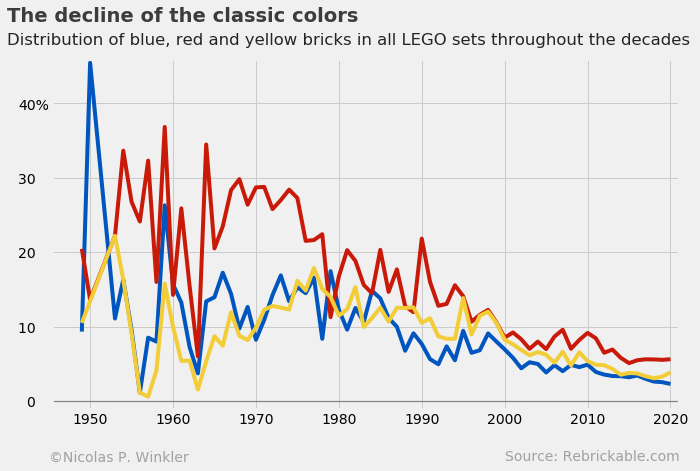

In [21]:
# Count the occurrence of each color and group by year
df_colors = df.groupby(['year', 'name_y', 'rgb']).size().reset_index(name='counts')
df_colors = df_colors.groupby(['year', 'name_y', 'rgb']).agg({'counts': 'sum'})

# Calculate the relative percentages
df_colors = df_colors.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
df_colors.columns = ['Year', 'Color', 'RGB', 'Percentage']

# Filter for red, blue and yellow
df_rby = df_colors[df_colors.Color.eq('Blue') | 
                   df_colors.Color.eq('Red') | 
                   df_colors.Color.eq('Yellow')]

# Fill the color palette based on the actual RGB values
cpalette = sns.color_palette('#' + df_rby.RGB.unique())

# Create figure and set plot style
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

# Plot with Seaborn (and distinguish with hue='Color')
ax = sns.lineplot(x='Year', y='Percentage', hue='Color', 
                  palette=cpalette, data=df_rby, legend=False)

# Set the axis limits
plt.ylim(-1, 46)
plt.xlim(xmax=2021)

# Create bold line at y=0
ax.axhline(y=0, color='#414141', linewidth=1.3, alpha=0.5)

# Set font size for the axis tick labels and specify y tick labels...
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_yticklabels(labels = ['','0   ', '10   ', '20   ', '30   ', '40%'])

# ... but hide the actual axis labels
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

# Make the title and subtitle
ax.text(x = 1940, y = 51, 
        s = "The decline of the classic colors", 
        fontsize = 19.5, weight = 'bold', alpha = .75)
ax.text(x = 1940, y = 48, 
        s = 'Distribution of blue, red and yellow bricks in all LEGO sets throughout the decades', 
        fontsize = 16.5, alpha = .85)

# Make the footer
ax.text(x = 1945, y = -8,
    s = '©Nicolas P. Winkler',
    fontsize = 14, color = 'grey', alpha=0.7);
ax.text(x = 2000, y = -8,
    s = 'Source: Rebrickable.com   ',
    fontsize = 14, color = 'grey', alpha=0.7);
# Show plot
plt.show()

## Plotting the Rise of New Colors

Let's now take a look *new* colors. For that I only care about *colors* that were introduced after 1990. The most notable color change certainly happend in 2003, when LEGO replaced some colors with more vibrant versions. Most notably the change from *light gray* and *dark gray* to *light bluish gray* and *dark bluish gray*.
For this example, I only look at the ten colors that were most popular in 2020.

In [7]:
# Get all colors before 1990 and in 2020 in separate dataframes
df_1990 = df_colors.loc[df_colors["Year"]<=1990]
df_2020 = df_colors.loc[df_colors["Year"]==2020]

# Sort the DataFrame by percentage
df_2020 = df_2020.sort_values(by=['Percentage'], ascending=False)

# Get the ten most popular new colors in 2020
# Filter df_2020 to only show colors that do not appear in df_1990
df_top10_new_colors = df_2020[~df_2020.Color.isin(df_1990.Color)].head(10)

# And now filter the DataFrame that contains all bricks to only contain the top10 new colors.
df_new_colors = df_colors[df_colors.Color.isin(df_top10_new_colors.Color)]

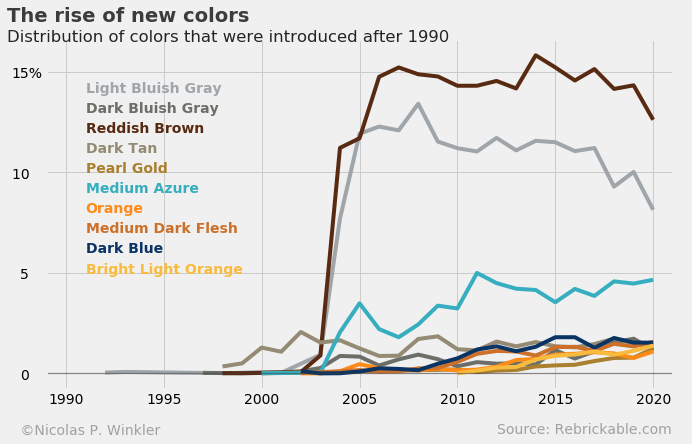

In [25]:
# Get all unique RGB codes from the top 10 new colors and build a color palette with it. This will be used for the plot later.
cpalette = sns.color_palette('#'+df_top10_new_colors.RGB.unique())
# Get the names of all colors and save in list
cnames = df_top10_new_colors.Color.unique()

# Create figure and set plot style
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# Plot with Seaborn (and distinguish with hue='Color')
ax = sns.lineplot(x='Year', y='Percentage', hue='Color', palette=cpalette, data=df_new_colors, legend=False)

# Set the axis limits
plt.xlim(1989, 2021)

# Create bold line at y=0
ax.axhline(y=0, color='#414141', linewidth=1.3, alpha=0.5)

# Set font size for the axis tick labels and specify y tick labels...
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

# ... but hide the actual axis labels
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

# Specify y ticks and labels...
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(labels = ['0   ', '5   ', '10   ', '15%'])

# Make the title and subtitle
ax.text(x = 1987, y = 17.5, s = "The rise of new colors", fontsize = 19.5, weight = 'bold', alpha = .75)
ax.text(x = 1987, y = 16.5, s = 'Distribution of colors that were introduced after 1990', fontsize = 16.5, alpha = .85)

# Make the footer
ax.text(x = 1987, y = -3,
    s = '   ©Nicolas P. Winkler',
    fontsize = 14, color = 'gray', alpha=0.7);
ax.text(x = 2012, y = -3,
    s = 'Source: Rebrickable.com   ',
    fontsize = 14, color = 'gray', alpha=0.7);
# Add labels of legend. The labels text is the color name, the labels color is the RGB code.
palette = sns.color_palette('#' + df_top10_new_colors.RGB.unique())
ax.text(x = 1991, y = 14, s = cnames[0], color = palette[0], weight = 'bold')
ax.text(x = 1991, y = 13, s = cnames[1], color = palette[1], weight = 'bold')
ax.text(x = 1991, y = 12, s = cnames[2], color = palette[2], weight = 'bold')
ax.text(x = 1991, y = 11, s = cnames[3], color = palette[3], weight = 'bold')
ax.text(x = 1991, y = 10, s = cnames[4], color = palette[4], weight = 'bold')
ax.text(x = 1991, y = 9, s = cnames[5], color = palette[5], weight = 'bold')
ax.text(x = 1991, y = 8, s = cnames[6], color = palette[6], weight = 'bold')
ax.text(x = 1991, y = 7, s = cnames[7], color = palette[7], weight = 'bold')
ax.text(x = 1991, y = 6, s = cnames[8], color = palette[8], weight = 'bold')
ax.text(x = 1991, y = 5, s = cnames[9], color = palette[9], weight = 'bold')

# Show plot
plt.show()